In [1]:
using Gen, Plots, LinearAlgebra

In [2]:
num_points = 50;
jitter = 0.1;

theta = .5
direction = [cos(theta), sin(theta)];
start = [0.,0.];

theta1 = .5;
direction1 = [cos(theta1), sin(theta1)];
theta2 = 2.;
direction2 = [cos(theta2), sin(theta2)];
start1 = [0.,-1.];
changepoint = 7.;
start2 = start1 + direction1 * changepoint


2-element Array{Float64,1}:
 6.143077933232609
 2.355978770229421

In [3]:
ts = collect(range(0., stop=10., length=num_points))
xs_simple = start[1] .+ ts*direction[1] + randn(num_points)*jitter
ys_simple = start[2] .+ ts*direction[2] + randn(num_points)*jitter

function line(t, dir, start)
    return dir*t + start
end
xs_complex = [t<changepoint ? line(t-randn()*jitter,direction1[1],start1[1]) : line(t-changepoint-randn()*jitter,direction2[1],start2[1]) for t in ts] .+ randn(num_points) * jitter;
ys_complex = [t<changepoint ? line(t-randn()*jitter,direction1[2],start1[2]) : line(t-changepoint-randn()*jitter,direction2[2],start2[2]) for t in ts] .+ randn(num_points) * jitter;


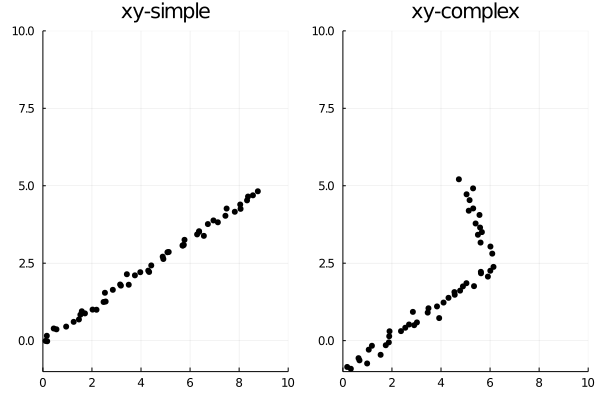

In [4]:
simple_plot = scatter(xs_simple, ys_simple, color="black", label=nothing, title="xy-simple", ylim=(-1, 10), xlim=(0,10))
complex_plot = scatter(xs_complex, ys_complex, color="black", label=nothing, title="xy-complex", ylim=(-1, 10), xlim=(0,10))
Plots.plot(simple_plot, complex_plot)

In [5]:
struct Interval
    l::Float64
    u::Float64
end

abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    x0::Float64
    y0::Float64
    angle::Float64
    interval::Interval
end

In [81]:
# 2-piece linear
@gen function generate_leaf_left(l::Float64, u::Float64)
    interval = Interval(l, u)
    x0 = ({:x0} ~ normal(0,1))
    y0 = ({:y0} ~ normal(0,1))
    angle = ({:angle} ~ uniform(0,pi))
    return LeafNode(x0, y0, angle, interval)
end
@gen function generate_leaf_right(l::Float64, u::Float64, x0::Float64, y0::Float64)
    interval = Interval(l, u)
    angle = ({:angle} ~ uniform(0,pi))
    return LeafNode(x0, y0, angle, interval)
end
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    len = interval.u - interval.l
    frac = ({:frac} ~ beta(2, 2))
    mid  = l + (u - l) * frac
    # left = ({:left} ~ generate_leaf_left(l, mid))
    # x0 = left.x0 + cos(left.angle)*len
    # y0 = left.y0 + sin(left.angle)*len
    # right = ({:right} ~ generate_leaf_right(mid, u, x0, y0))
    lint = Interval(l,mid)
    rint = Interval(mid,r)
    x0 = ({:x0} ~ normal(0,1))
    y0 = ({:y0} ~ normal(0,1))
    angle1 = ({:angle} ~ uniform(0,pi))
    angle2 = ({:angle} ~ uniform(0,pi))
    x1 = x0 + cos(angle1)*len
    y1 = y0 + sin(angle1)*len
    left  = LeafNode(x0,y0,angle1,lint)
    right = LeafNode(x1,y1,angle2,rint)
    return InternalNode(left, right, interval)
end;

In [82]:
function render_node!(node::LeafNode)
    length = node.interval.u - node.interval.l
    plot!([node.x0, node.x0+cos(node.angle)*length], [node.y0, node.y0+sin(node.angle)*length], label=nothing, linewidth=5)
end

function render_node!(node::InternalNode)
    render_node!(node.left)
    render_node!(node.right)
end;

function render_segments_trace(trace; xlim=(0,1))
    node = get_retval(trace)
    fig = plot(xlim=xlim, ylim=(-5, 5))
    render_node!(node)
    return fig
end;

function gridded(renderer::Function, traces)
    Plots.plot(map(renderer, traces)..., ylim=(-5.,5.), xlim=(-5.,5.))
end;

function do_inference(model, xs, ys, amount_of_computation)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

function do_inference_lml(model, xs, ys, amount_of_computation)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    (trace, lml_est) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace[argmin(lml_est)]
end;

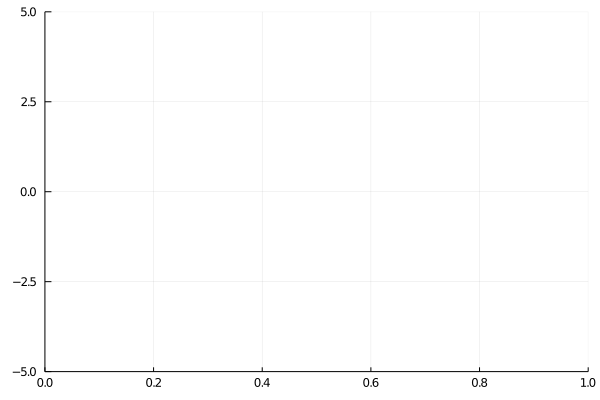

In [88]:
trace = Gen.simulate(generate_segments, (0., 1.))
render_segments_trace(trace)


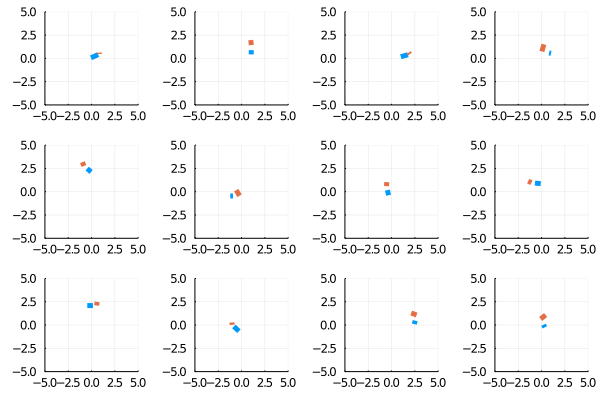

In [84]:
traces = [Gen.simulate(generate_segments, (0., 1.)) for i=1:12]
gridded(render_segments_trace, traces)

In [53]:
# get_value_at searches a binary tree for
# the leaf node containing some value.
function get_value_at(t::Float64, node::LeafNode)
    @assert t >= node.interval.l && t <= node.interval.u
    length = t - node.interval.l
    return [node.x0 + cos(node.angle)*length, node.y0 + sin(node.angle)*length]
end

function get_value_at(t::Float64, node::InternalNode)
    @assert t >= node.interval.l && t <= node.interval.u
    if t <= node.left.interval.u
        get_value_at(t, node.left)
    else
        get_value_at(t, node.right)
    end
end

# Our full model
@gen function changepoint_model(ts::Vector{Float64})
    node = ({:tree} ~ generate_segments(minimum(ts), maximum(ts)))
    noise = ({:noise} ~ gamma(0.5, 0.5))
    for (i, t) in enumerate(ts)
        {(:y, i)} ~ normal(get_value_at(t, node), noise)
    end
    return node
end;

In [54]:
function render_changepoint_model_trace(trace; show_data=true)
    xs = Gen.get_args(trace)[1]
    node = Gen.get_retval(trace)
    fig = render_segments_trace(trace; xlim=(minimum(xs), maximum(xs)))
    render_node!(node)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        scatter!(xs, ys, c="gray", label=nothing, alpha=0.2, markersize=3)
    end
end;

In [64]:
traces = [Gen.simulate(changepoint_model, (ts,)) for i=1:12]
gridded(render_changepoint_model_trace, traces)

MethodError: MethodError: no method matching random(::Gen.Normal, ::Array{Float64,1}, ::Float64)
Closest candidates are:
  random(::Gen.Normal, !Matched::Real, ::Real) at /home/grace/.julia/packages/Gen/ME5el/src/modeling_library/distributions/normal.jl:128
  random(!Matched::Gen.BroadcastedNormal, ::Union{Real, AbstractArray{#s54,N} where N where #s54<:Real}, ::Union{Real, AbstractArray{#s53,N} where N where #s53<:Real}) at /home/grace/.julia/packages/Gen/ME5el/src/modeling_library/distributions/normal.jl:134
  random(!Matched::Gen.TransformedDistribution{T,U}, ::Any...) where {T, U} at /home/grace/.julia/packages/Gen/ME5el/src/modeling_library/dist_dsl/transformed_distribution.jl:20
  ...

In [65]:
traces = [do_inference(changepoint_model, xs_dense, ys_simple, c) for c=0:2000:30000];
gridded(render_changepoint_model_trace, traces)

UndefVarError: UndefVarError: xs_dense not defined

In [66]:
traces = [do_inference(changepoint_model, xs_dense, ys_complex, c) for c=0:2000:30000];
gridded(render_changepoint_model_trace, traces)


UndefVarError: UndefVarError: xs_dense not defined

In [67]:
# xs_liane = [-2.18806071, -2.68669785, -2.93349052, -2.76685382, -1.86824144,
# -1.43135383, -1.30331619, -0.85012829, -0.9870126 , -0.38060227,
# -0.28228596,  1.24643695, -0.42600598, -0.35960069,  1.01478478,
#  0.51319791,  0.45387564,  0.90201174,  0.98141609,  1.1384701 ,
#  2.65573501,  2.86300916,  1.7258706 ];
# ys_liane = [-6.72809035, -6.67905572, -6.02691043, -6.36779675, -6.34044988,
# -5.32152449, -5.45083288, -3.74550456, -3.81769449, -3.64797366,
# -4.70583338, -4.95114782, -5.38420009, -6.4868379 , -6.01582226,
# -6.29645579, -7.58384064, -7.71765804, -8.55792185, -8.74195271,
# -8.73289836, -9.18596897, -9.36630242];


# xs_liane = [-2.18806071, -2.68669785, -2.93349052, -2.76685382, -1.86824144,
# -1.43135383, -1.30331619, -0.85012829, -0.9870126 , -0.38060227,
# -0.28228596,  1.24643695, -0.42600598, -0.35960069,  1.01478478,
#  0.51319791,  0.45387564,  0.90201174,  0.98141609,  1.1384701 ,
#  2.65573501,  2.86300916,  1.7258706 ,  2.65046183,  2.97414198,
#  2.40235515,  3.3543436 ,  3.22973211,  4.56750518,  4.16012363,
#  4.54294248,  4.7417621 ,  5.55531661,  5.13734162,  4.62700202,
#  5.30098008,  5.81277292,  5.83365505,  6.38784988,  6.02484585,
#  6.35808773,  6.60774027,  7.25847494];
# ys_liane = [ -6.72809035,  -6.67905572,  -6.02691043,  -6.36779675,
# -6.34044988,  -5.32152449,  -5.45083288,  -3.74550456,
# -3.81769449,  -3.64797366,  -4.70583338,  -4.95114782,
# -5.38420009,  -6.4868379 ,  -6.01582226,  -6.29645579,
# -7.58384064,  -7.71765804,  -8.55792185,  -8.74195271,
# -8.73289836,  -9.18596897,  -9.36630242, -10.78964437,
# -10.01079095, -10.84251265, -11.50790401, -12.49717721,
# -12.54523245, -13.09986733, -12.91483388, -14.07298124,
# -14.59682167, -14.55358042, -14.4180429 , -15.16548724,
# -14.87218909, -15.76818644, -16.11701517, -16.60641028,
# -18.22116204, -17.18179336, -17.93461457];

# xs_liane = [-6.2305365567775395, -4.686157116702581, -5.391437965236277, -4.793120124623548, -5.818982435784096, -4.492687487986062, -3.920619567814021, -2.9846755388114334, -2.82930589811918, -3.105131818399224, -2.5605968491110174, -1.7194697096289013, -1.372195764181541, -0.8183771475642129, -0.23523025489516092, 0.2592760253663011, -0.037601483726853284, 0.6454446632942834, 0.10924015917404495, 1.9534220901406614, 0.8946720422019753, 2.187119129180757, 1.5957206671037132, 2.98783331237738, 2.836859010041827, 3.9835427942277435, 4.204927281702297, 4.031182462561404, 5.611414345722474, 4.340614223945397, 5.058249588285063, 4.112527333885778, 4.534950658140063, 5.421265240558161, 5.359036003353115, 5.205090191143169, 6.3217272406063625, 5.805059407273506, 6.8316718184295695, 6.765425574318771, 6.439684052480675, 7.066023748653033, 7.7770604798675, 7.25186728708656, 7.772726708214344, 7.642958873742124, 7.5781709893505775, 7.772189366533376, 8.68076296242428, 9.12816648768521, 8.564345362895152, 9.427412474791835, 9.272648643520066, 10.280690517056627, 10.052478229184473, 10.54440846249798, 10.320752306735837, 10.511865470082784, 11.747358584032847, 11.090096887651756, 11.969990591833483]
# ys_liane = [-13.538605694418498, -14.366305352731466, -13.014661071000596, -12.661358046982926, -11.562098685068994, -11.933430633805825, -10.822830115335982, -11.847484224062798, -11.3915967146839, -9.33754374065651, -10.30965660792003, -8.930402211164697, -9.619561900615958, -7.817046719110923, -8.872233575844717, -7.729974554386155, -7.57108485716535, -6.9978214059442205, -7.235200122313719, -5.721988275889792, -6.015382547445293, -5.598493897429641, -5.125985280915559, -5.0754533512001245, -5.012387325846921, -6.080170607697436, -5.447166235196184, -6.1940415339145245, -5.804115254467495, -6.960624046027133, -8.21172775907961, -8.173758944942094, -9.898360971760452, -9.115976578733594, -10.755292412695104, -9.85251026490128, -10.722843570107065, -11.844427713035945, -12.387792519187226, -13.565524794951722, -12.815327072449026, -13.461042783369646, -15.326658690143468, -15.550113907272662, -15.835361697714053, -16.400451303355908, -15.79978839971521, -17.749797304483025, -17.39635654521202, -17.86343133398652, -18.45045187617788, -19.232017851311806, -20.506724934425996, -20.924136202751026, -20.665939498514604, -21.211803774707437, -21.830752119005126, -21.802526579510438, -22.710622684313847, -23.685032638212448, -24.276847259578773]

xs_liane = [-5.950857394849689, -5.732010560831773, -5.580991994056934, -5.325627078129187, -4.997871406373859, -4.690249541976312, -4.502801279432661, -4.198802578982614, -3.8652273967792414, -3.6428990937063213, -3.377558214902028, -3.1656570504882184, -2.830237123073675, -2.5281778150720604, -2.375297793708614, -1.9401933873715762, -1.6319046597476836, -1.6717638204182148, -1.362654961717607, -0.9693426291864525, -0.811144262538797, -0.5480708745819656, -0.32266374948988513, 0.05383282297858155, 0.4016871505526071, 0.660565225479464, 0.8550662882052231, 0.7607954986603729, 1.0312793009619847, 0.8979837945988044, 0.9735902060931276, 1.2348843663875695, 1.0928824145364817, 1.227255075623881, 1.1757547665617354, 1.0999641340307935, 1.1917436262709766, 0.9728847526387326, 1.1692510845270632, 1.278526190484237, 1.2052413081734674, 1.2520957076015669, 1.2653249232564354, 1.1170372715656347, 1.3916064681498654, 1.338226336426837, 1.2119699846671146, 1.3964169886158053, 1.5054479944712122, 1.5788396428356881, 1.3630872692620954, 1.5306201668825816, 1.7288599825079936, 1.6389469600708257, 1.450110864118712, 1.742881165478771, 1.4450937916425022, 1.6608816089351017, 1.7358157777226857, 1.6330369315350954, 1.9033722624552583]
ys_liane = [-13.962826731948132, -13.6158458546513, -13.288690845417696, -12.878581968295736, -12.418912894929226, -12.194764895371145, -11.738201280520876, -11.412386793782822, -10.971006926703087, -10.661435707109753, -10.348379284735742, -9.864703294279812, -9.535258910001595, -9.183148888409631, -8.780725973290599, -8.583211783612073, -8.076055050588135, -7.625419566760801, -7.324452518333433, -6.7199161049526275, -6.45704037194385, -6.047466726957722, -5.764535381921893, -5.413483305869026, -5.211529710062647, -4.678972607715271, -4.434929059461678, -4.585310762667825, -4.9228541200239535, -5.355922713224732, -5.7583352804706305, -6.298447589241116, -6.633125759943555, -7.293069009679432, -7.420856555405638, -7.918603844111726, -8.241926429018134, -8.610009090764237, -9.158611408700255, -9.515530557305553, -10.115289822024357, -10.313414513976078, -10.822462000953001, -11.196390613444262, -11.64230335894282, -12.09530361338669, -12.50917782304498, -12.95475985019972, -13.259601481366905, -13.715924753517145, -14.232550175047923, -14.55624473483772, -15.160620132788933, -15.372811349780754, -15.689990396433817, -16.249640966579886, -16.927653384253517, -17.063515834117517, -17.621194875062653, -17.944801585157652, -18.298492962768307]

61-element Array{Float64,1}:
 -13.962826731948132
 -13.6158458546513
 -13.288690845417696
 -12.878581968295736
 -12.418912894929226
 -12.194764895371145
 -11.738201280520876
 -11.412386793782822
 -10.971006926703087
 -10.661435707109753
   ⋮
 -15.160620132788933
 -15.372811349780754
 -15.689990396433817
 -16.249640966579886
 -16.927653384253517
 -17.063515834117517
 -17.621194875062653
 -17.944801585157652
 -18.298492962768307

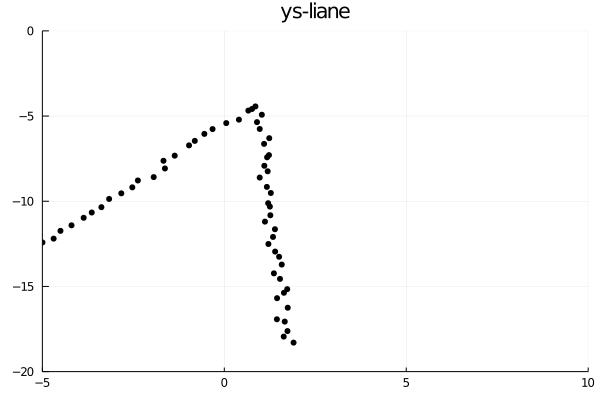

In [68]:
liane_plot = scatter(xs_liane, ys_liane, color="black", label=nothing, title="ys-liane", ylim=(-20,0), xlim=(-5,10))
Plots.plot(liane_plot)

In [69]:
# lml_est = [do_inference_lml(changepoint_model, xs_liane, ys_liane, c) for c=0:2000:30000];
traces = [do_inference(changepoint_model, xs_liane, ys_liane, c) for c=0:2000:30000];


MethodError: MethodError: no method matching logpdf(::Gen.Normal, ::Float64, ::Array{Float64,1}, ::Float64)
Closest candidates are:
  logpdf(::Gen.Normal, ::Real, !Matched::Real, ::Real) at /home/grace/.julia/packages/Gen/ME5el/src/modeling_library/distributions/normal.jl:57
  logpdf(!Matched::Gen.BroadcastedNormal, ::Union{Real, AbstractArray{#s54,N} where N where #s54<:Real}, ::Union{Real, AbstractArray{#s53,N} where N where #s53<:Real}, ::Union{Real, AbstractArray{#s52,N} where N where #s52<:Real}) at /home/grace/.julia/packages/Gen/ME5el/src/modeling_library/distributions/normal.jl:65
  logpdf(!Matched::Gen.TransformedDistribution{T,U}, ::T, ::Any...) where {T, U} at /home/grace/.julia/packages/Gen/ME5el/src/modeling_library/dist_dsl/transformed_distribution.jl:28
  ...

In [70]:
# println(lml_est)

In [71]:
gridded(render_changepoint_model_trace, traces)

ErrorException: No random choice or generative function call at address (:y, 1)